# Taylor approximations to color conversion

This notebook shows how to come up with all these magic constants that appear in the approximations to `LinearRgb` in my [go-colorful](https://github.com/lucasb-eyer/go-colorful) library in order to speed them up at almost no loss in accuracy.

The gist is to compute a Taylor expansion up to a degree that gives enough accuracy.
Taylor expansions work well for relatively linear-ish functions, as `LinearRgb` is.

Doing this is especially easy thanks to the SymPy library which has symbolic Taylor expansion built-in!

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np

from sympy import *
init_printing()

The following is the conversion from RGB to linear RGB (aka. gamma-correction), where I'm dropping the conditional part for very small values of `x` as a first approximation.

In [4]:
def linear_rgb(x):
    return ((x+0.055)/1.055)**2.4

Now, we can use SymPy to create a symbolic version of that equation, and compute a symbolic Taylor expansion around $0.5$ (the middle of our target range) up to the fourth degree:

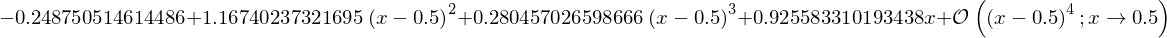

In [7]:
x = Symbol('x', real=True)
series(linear_rgb(x), x, x0=0.5, n=4)

In order to use it numerically, we will "drop the O", which means do the actual approximation, and "lambdify" the function, which turns a symbolic function into a NumPy function:

In [9]:
fast_linear_rgb = lambdify([x], series(linear_rgb(x), x, x0=0.5, n=4).removeO())

As additional heuristic approximations, we'll include simply squaring the values, which should also be very fast, but quite wrong. Then, plot all these functions in order to see their behaviour, and compute errors:

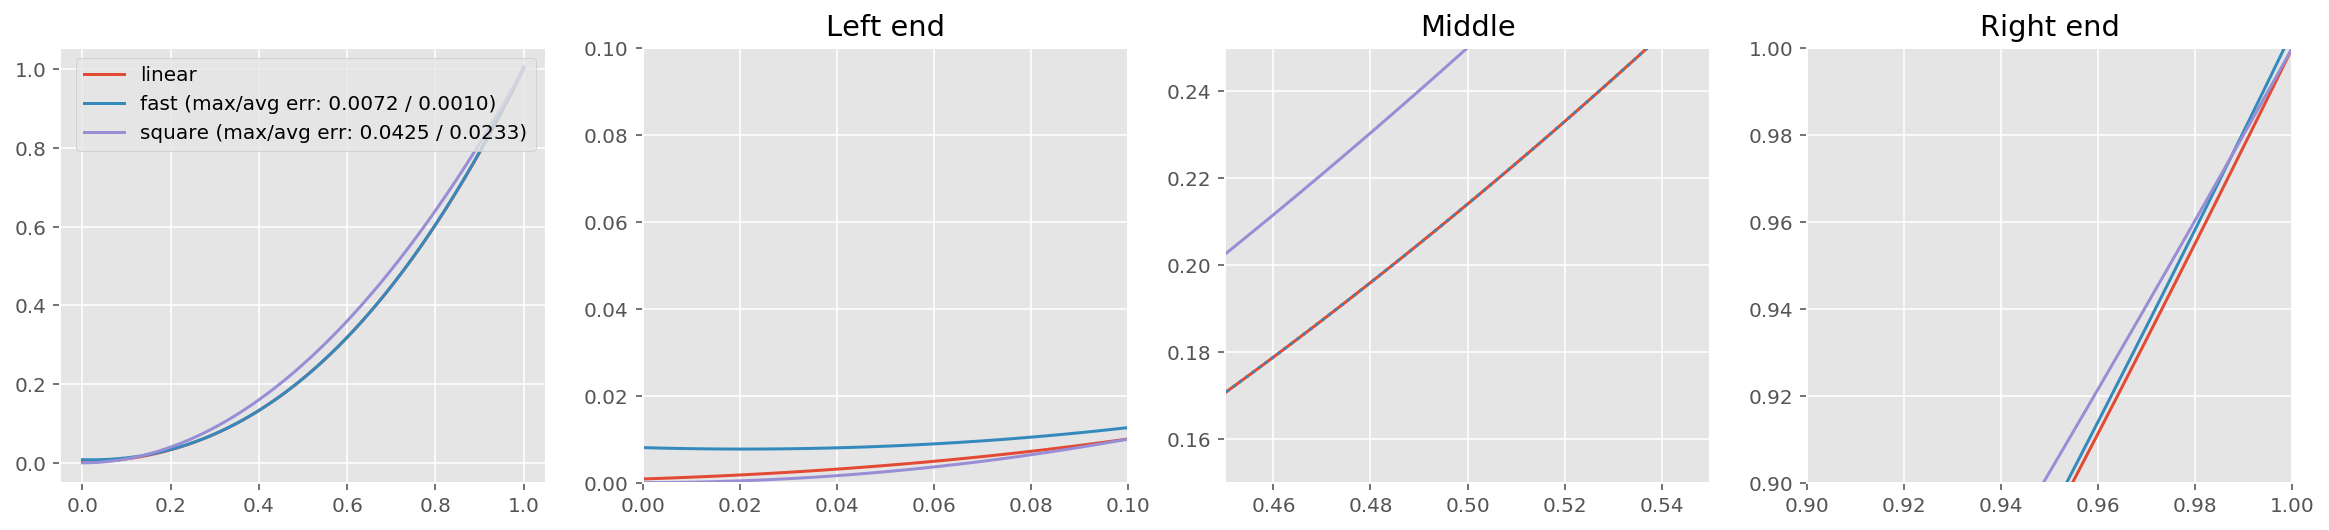

In [67]:
X = np.linspace(0,1,1001)

ref = linear_rgb(X)  # The (almost) correct implementation.
fast = fast_linear_rgb(X)  # The Taylor approximation
square = X*X  # The approximation by squaring.

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,4))
ax1.plot(X, ref, label='linear')
ax1.plot(X, fast, label='fast (max/avg err: {:.4f} / {:.4f})'.format(np.max(np.abs(ref - fast)),
                                                                     np.mean(np.abs(ref - fast))))
ax1.plot(X, square, label='square (max/avg err: {:.4f} / {:.4f})'.format(np.max(np.abs(ref - square)),
                                                                         np.mean(np.abs(ref - square))))
ax2.plot(X, ref)
ax2.plot(X, fast)
ax2.plot(X, square)
ax2.set_xlim(0, 0.1)
ax2.set_ylim(0, 0.1)
ax2.set_title("Left end")
ax3.plot(X, ref)
ax3.plot(X, fast, ls=':')
ax3.plot(X, square)
ax3.set_xlim(0.45, 0.55)
ax3.set_ylim(0.15, 0.25)
ax3.set_title("Middle")
ax4.plot(X, ref)
ax4.plot(X, fast)
ax4.plot(X, square)
ax4.set_xlim(0.9, 1)
ax4.set_ylim(0.9, 1)
ax4.set_title("Right end")

ax1.legend();

# The inverse function (for Lab->RGB)

The inverse function is significantly more difficult, because its left part is highly non-linear and changes much faster than the rest of the function.

So what we do here, in order to keep reasonable accuracy, is split it into three parts with three different approximations. You will notice that the leftmost part has quite large coefficients, which hints to the approximation being worse/"harder".

In [35]:
def delinear_rgb(x):
    return 1.055*(x**(1.0/2.4)) - 0.055

fast_delinear_rgb_part1 = lambdify([x], series(delinear_rgb(x), x, x0=0.015, n=6).removeO())
fast_delinear_rgb_part2 = lambdify([x], series(delinear_rgb(x), x, x0=0.03, n=6).removeO())
fast_delinear_rgb_part3 = lambdify([x], series(delinear_rgb(x), x, x0=0.6, n=6).removeO())

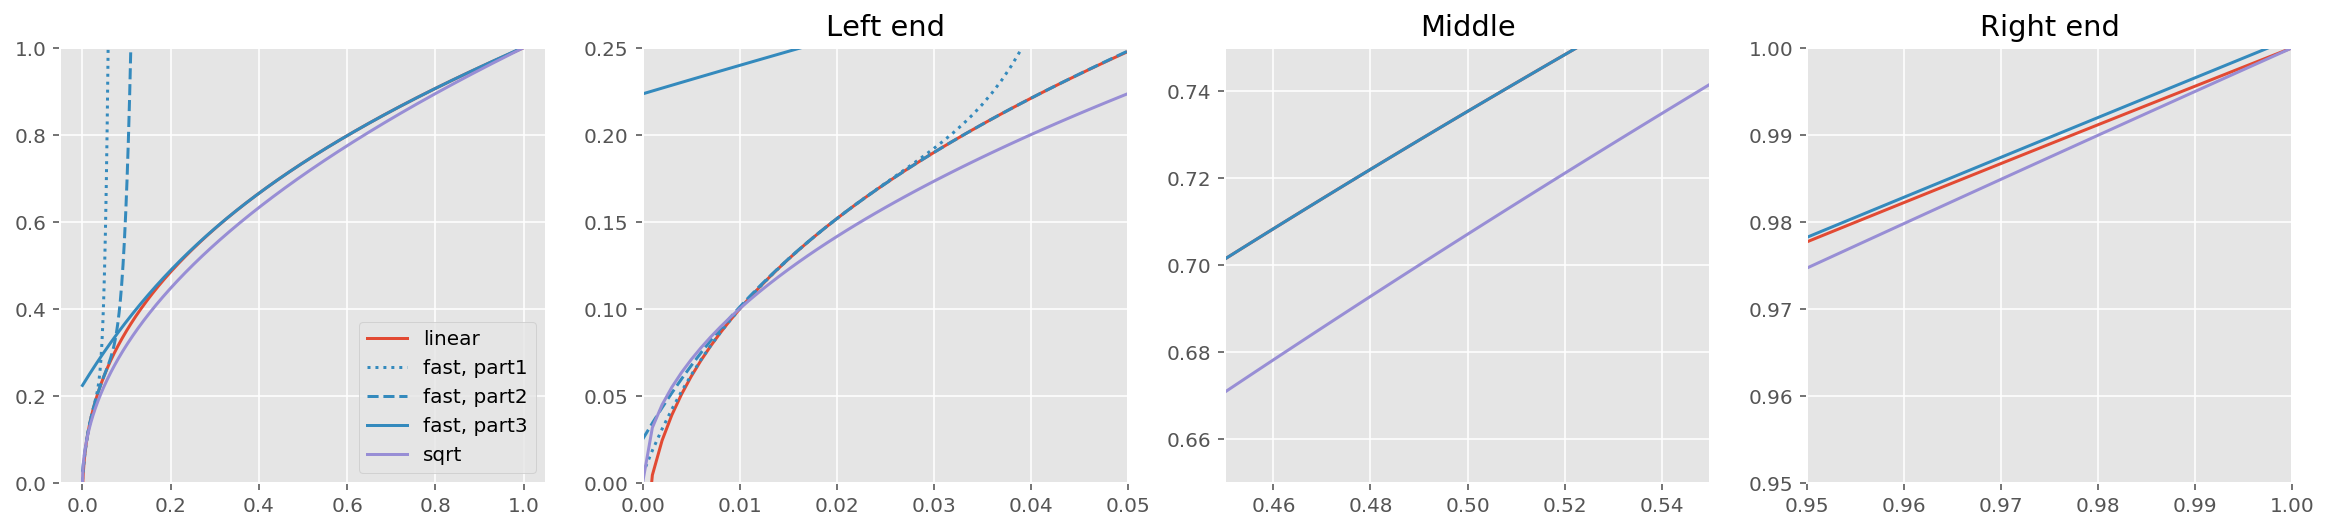

In [69]:
ref = delinear_rgb(X)
fast1 = fast_delinear_rgb_part1(X)
fast2 = fast_delinear_rgb_part2(X)
fast3 = fast_delinear_rgb_part3(X)
sqrt = np.sqrt(X)

def plot(ax):
    ax.plot(X, ref, label='linear')
    l, = ax.plot(X, fast1, label='fast, part1', ls=':')
    ax.plot(X, fast2, label='fast, part2', c=l.get_color(), ls='--')
    ax.plot(X, fast3, label='fast, part3', c=l.get_color(), ls='-')
    ax.plot(X, sqrt, label='sqrt')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,4))
plot(ax1)
ax1.set_ylim(0, 1)
plot(ax2)
ax2.set_xlim(0, 0.05)
ax2.set_ylim(0, 0.25)
ax2.set_title("Left end")
plot(ax3)
ax3.set_xlim(0.45, 0.55)
ax3.set_ylim(0.65, 0.75)
ax3.set_title("Middle")
plot(ax4)
ax4.set_xlim(0.95, 1)
ax4.set_ylim(0.95, 1)
ax4.set_title("Right end")

ax1.legend()